# HVNM Stress Relaxation: Quad-Exponential + Amplified Plateau

## Introduction

After a step strain, the HVNM exhibits **quad-exponential relaxation** from four relaxation modes (E, D, I networks) plus a reinforced permanent plateau $G_P X(\phi)$. The model captures the slow interphase relaxation mode characteristic of nanoparticle-filled vitrimers, where confined polymer chains near NP surfaces exhibit higher activation barriers ($E_a^{int} > E_a^{mat}$). At long times, the modulus plateaus at $G(\infty) = G_P X(\phi)$, amplified by the Guth-Gold factor. This protocol validates the dual factor-of-2 timescales and confirms $\phi=0$ recovery of HVM.

> **Handbook:** See [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) for ODE formulation and [Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) for multi-temperature Arrhenius analysis to extract $E_a^{mat}$ and $E_a^{int}$.

## Learning Objectives

- Simulate step-strain stress relaxation in nanocomposites
- Observe quad-exponential decay from E, D, matrix, and interphase networks
- Confirm $G(0^+) \approx G_{tot}$ and $G(\infty) \approx G_P X$ (amplified plateau)
- Explore interphase slow mode from $\beta_I > 1$

## Prerequisites
- **Notebook 01** — SAOS fundamentals

## Estimated Runtime
- ~1-2 min (ODE integration with 17-component state)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

After a step strain γ₀, the stress relaxes as:

$$G(t) = G_P \cdot X + G_E \exp(-t/\tau_m) + G_D \exp(-k_d^D t) + G_{I,eff} \cdot X_I \cdot \exp(-t/\tau_I)$$

where:
- $\tau_m = 1/(2 k_{BER,mat,0})$ is the matrix vitrimer relaxation time
- $\tau_I = 1/(2 k_{BER,int,0})$ is the interphase vitrimer relaxation time
- $X = 1 + \phi \cdot (\beta_I - 1) \geq 1$ is the plateau amplification factor
- $X_I = 1 + \phi \cdot \beta_I \geq 1$ is the interphase amplification factor
- $G_{I,eff} = (X_I - X) \cdot G_P$ is the effective interphase modulus

**Key features:**
- $G(0^+) = G_P \cdot X + G_E + G_D + G_{I,eff} \cdot X_I$ (total modulus)
- $G(\infty) = G_P \cdot X$ (amplified permanent plateau from nanoparticles)
- Four decay rates: E (matrix vitrimer), D (dissociative), interphase (vitrimer), and permanent
- Interphase typically slower if $\beta_I > 1$ (enhanced BER activation barrier)
- $\phi = 0$ recovers HVM: $G(\infty) = G_P$

## 3. Relaxation Simulation

In [3]:
model = HVNMLocal()
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("phi", 0.1)
model.parameters.set_value("beta_I", 3.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("V_act", 1e-5)
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

X = model.X_phi
X_I = model.X_I
G_I_eff = model.G_I_eff
G_P_eff = model.G_P * X
G_tot = G_P_eff + model.G_E + model.G_D + G_I_eff * X_I

tau_E = model.get_vitrimer_relaxation_time()
tau_I = model.get_interphase_relaxation_time()
tau_D = 1.0 / model.k_d_D

print(f"G_tot      = {G_tot:.0f} Pa")
print(f"G_P*X      = {G_P_eff:.0f} Pa (amplified long-time plateau)")
print(f"X          = {X:.3f} (Guth-Gold amplification)")
print(f"X_I        = {X_I:.3f} (interphase amplification)")
print(f"G_I_eff*X_I= {G_I_eff * X_I:.0f} Pa (interphase contribution)")
print(f"τ_E_eff    = {tau_E:.4f} s (matrix vitrimer)")
print(f"τ_I_eff    = {tau_I:.4f} s (interphase vitrimer)")
print(f"τ_D        = {tau_D:.4f} s (dissociative)")

G_tot      = 14369 Pa
G_P*X      = 6955 Pa (amplified long-time plateau)
X          = 1.391 (Guth-Gold amplification)
X_I        = 1.478 (interphase amplification)
G_I_eff*X_I= 3414 Pa (interphase contribution)
τ_E_eff    = 43.4593 s (matrix vitrimer)
τ_I_eff    = 1350.4308 s (interphase vitrimer)
τ_D        = 0.1000 s (dissociative)


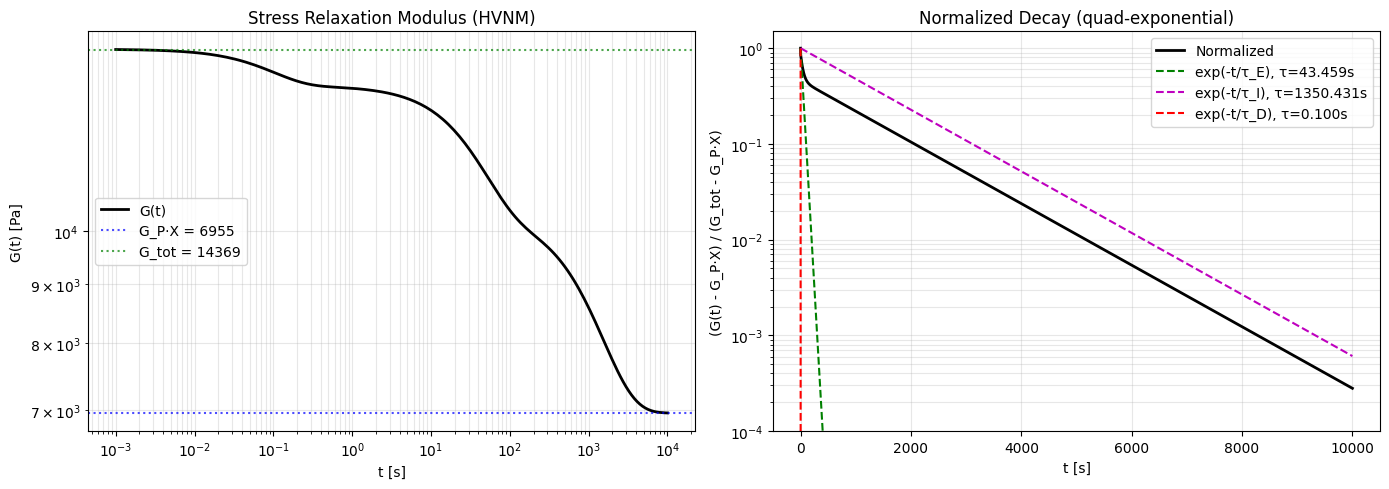

In [4]:
t = np.logspace(-3, 4, 200)
G_t = model.simulate_relaxation(t, gamma_step=0.01)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log plot
ax1.loglog(t, G_t, "k-", lw=2, label="G(t)")
ax1.axhline(G_P_eff, color="blue", ls=":", alpha=0.7, label=f"G_P·X = {G_P_eff:.0f}")
ax1.axhline(G_tot, color="green", ls=":", alpha=0.7, label=f"G_tot = {G_tot:.0f}")
ax1.set_xlabel("t [s]")
ax1.set_ylabel("G(t) [Pa]")
ax1.set_title("Stress Relaxation Modulus (HVNM)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Normalized semi-log
G_norm = (np.array(G_t) - G_P_eff) / (G_tot - G_P_eff)
ax2.semilogy(t, G_norm, "k-", lw=2, label="Normalized")
ax2.semilogy(t, np.exp(-t / tau_E), "g--", lw=1.5, label=f"exp(-t/τ_E), τ={tau_E:.3f}s")
ax2.semilogy(t, np.exp(-t / tau_I), "m--", lw=1.5, label=f"exp(-t/τ_I), τ={tau_I:.3f}s")
ax2.semilogy(t, np.exp(-t / tau_D), "r--", lw=1.5, label=f"exp(-t/τ_D), τ={tau_D:.3f}s")
ax2.set_xlabel("t [s]")
ax2.set_ylabel("(G(t) - G_P·X) / (G_tot - G_P·X)")
ax2.set_title("Normalized Decay (quad-exponential)")
ax2.legend()
ax2.set_ylim(1e-4, 1.5)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Component Decomposition

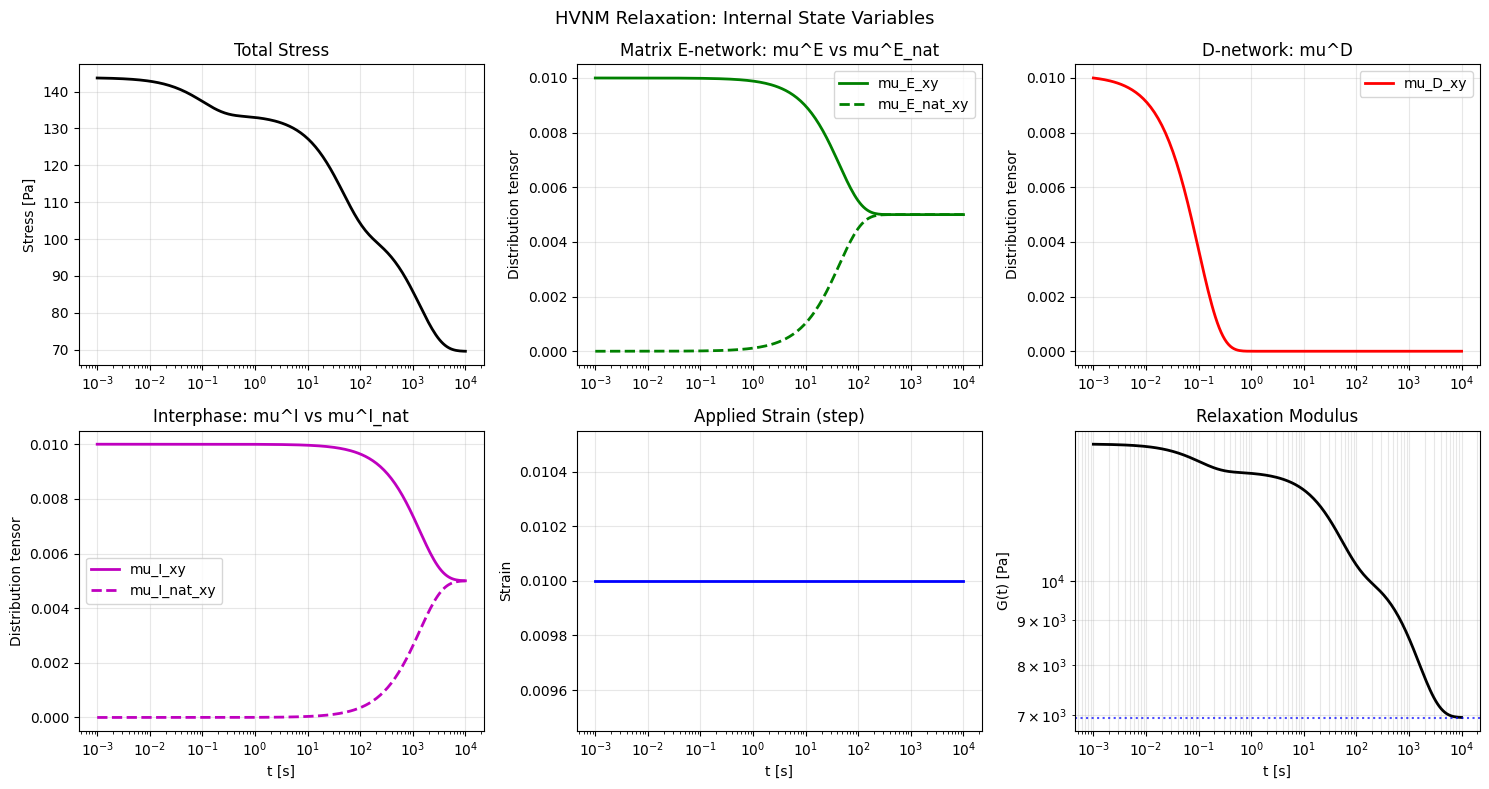

In [5]:
result = model.simulate_relaxation(t, gamma_step=0.01, return_full=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Total stress
axes[0, 0].semilogx(t, result["stress"], "k-", lw=2)
axes[0, 0].set_ylabel("Stress [Pa]")
axes[0, 0].set_title("Total Stress")
axes[0, 0].grid(True, alpha=0.3)

# E-network (matrix)
axes[0, 1].semilogx(t, result["mu_E_xy"], "g-", lw=2, label="mu_E_xy")
axes[0, 1].semilogx(t, result["mu_E_nat_xy"], "g--", lw=2, label="mu_E_nat_xy")
axes[0, 1].set_ylabel("Distribution tensor")
axes[0, 1].set_title("Matrix E-network: mu^E vs mu^E_nat")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# D-network
axes[0, 2].semilogx(t, result["mu_D_xy"], "r-", lw=2, label="mu_D_xy")
axes[0, 2].set_ylabel("Distribution tensor")
axes[0, 2].set_title("D-network: mu^D")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Interphase network
axes[1, 0].semilogx(t, result["mu_I_xy"], "m-", lw=2, label="mu_I_xy")
axes[1, 0].semilogx(t, result["mu_I_nat_xy"], "m--", lw=2, label="mu_I_nat_xy")
axes[1, 0].set_ylabel("Distribution tensor")
axes[1, 0].set_xlabel("t [s]")
axes[1, 0].set_title("Interphase: mu^I vs mu^I_nat")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Applied strain (step)
gamma_step_arr = np.full_like(t, 0.01)
axes[1, 1].semilogx(t, gamma_step_arr, "b-", lw=2)
axes[1, 1].set_ylabel("Strain")
axes[1, 1].set_xlabel("t [s]")
axes[1, 1].set_title("Applied Strain (step)")
axes[1, 1].grid(True, alpha=0.3)

# Relaxation modulus
axes[1, 2].loglog(t, G_t, "k-", lw=2)
axes[1, 2].axhline(G_P_eff, color="blue", ls=":", alpha=0.7)
axes[1, 2].set_ylabel("G(t) [Pa]")
axes[1, 2].set_xlabel("t [s]")
axes[1, 2].set_title("Relaxation Modulus")
axes[1, 2].grid(True, alpha=0.3, which="both")

plt.suptitle("HVNM Relaxation: Internal State Variables", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Filler Volume Fraction Comparison

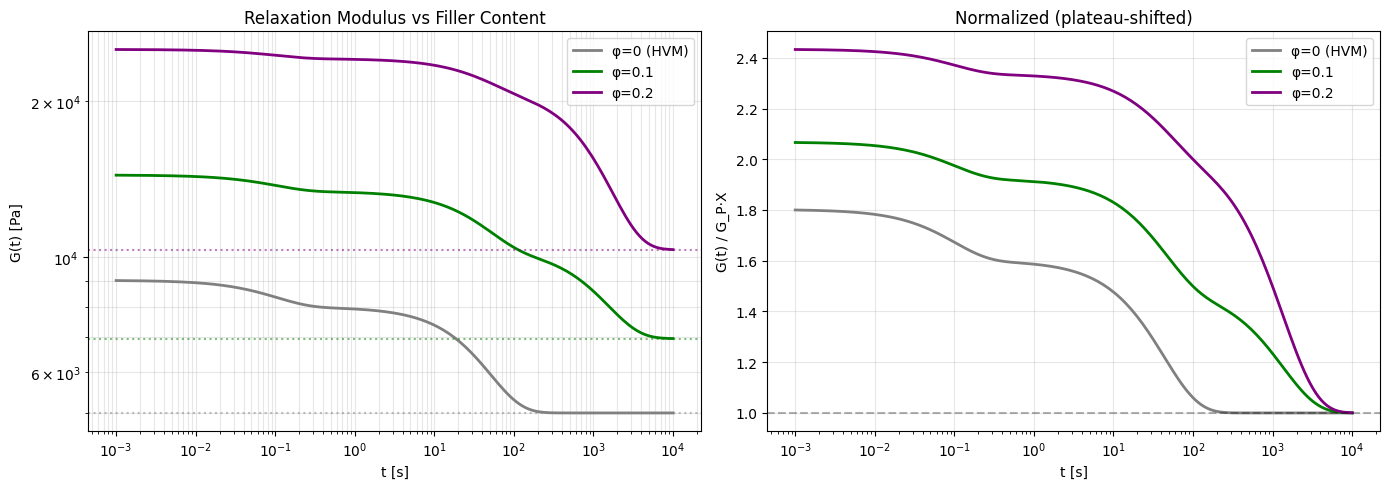


Plateau Amplification:
φ=0.0: X=1.000, G_P·X=5000 Pa
φ=0.1: X=1.391, G_P·X=6955 Pa
φ=0.2: X=2.064, G_P·X=10320 Pa


In [6]:
phi_values = [0.0, 0.1, 0.2]
colors = ["gray", "green", "purple"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for phi, color in zip(phi_values, colors):
    model_phi = HVNMLocal()
    model_phi.parameters.set_value("G_P", 5000.0)
    model_phi.parameters.set_value("G_E", 3000.0)
    model_phi.parameters.set_value("G_D", 1000.0)
    model_phi.parameters.set_value("phi", phi)
    model_phi.parameters.set_value("beta_I", 3.0)
    model_phi.parameters.set_value("nu_0", 1e10)
    model_phi.parameters.set_value("E_a", 80e3)
    model_phi.parameters.set_value("V_act", 1e-5)
    model_phi.parameters.set_value("T", 350.0)
    model_phi.parameters.set_value("k_d_D", 10.0)
    
    X_phi = model_phi.X_phi
    G_P_eff_phi = model_phi.G_P * X_phi
    
    G_t_phi = model_phi.simulate_relaxation(t, gamma_step=0.01)
    
    label = f"φ={phi:.1f}" if phi > 0 else "φ=0 (HVM)"
    ax1.loglog(t, G_t_phi, color=color, lw=2, label=label)
    ax1.axhline(G_P_eff_phi, color=color, ls=":", alpha=0.5)
    
    # Normalized
    ax2.semilogx(t, np.array(G_t_phi) / G_P_eff_phi, color=color, lw=2, label=label)

ax1.set_xlabel("t [s]")
ax1.set_ylabel("G(t) [Pa]")
ax1.set_title("Relaxation Modulus vs Filler Content")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("t [s]")
ax2.set_ylabel("G(t) / G_P·X")
ax2.set_title("Normalized (plateau-shifted)")
ax2.axhline(1.0, color="black", ls="--", alpha=0.3)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nPlateau Amplification:")
for phi in phi_values:
    X_phi = 1 + 2.5*phi + 14.1*phi**2
    print(f"φ={phi:.1f}: X={X_phi:.3f}, G_P·X={5000*X_phi:.0f} Pa")

## 6. Relaxation Spectrum

In [7]:
model = HVNMLocal()
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("phi", 0.1)
model.parameters.set_value("beta_I", 3.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

spectrum = model.get_relaxation_spectrum()
print("Discrete Relaxation Spectrum (HVNM):")
print(f"{'Network':<15} {'G_i [Pa]':>10} {'τ_i [s]':>12}")
print("-" * 40)
for G_i, tau_i in spectrum:
    if np.isinf(tau_i):
        print(f"{'Permanent (P)':<15} {G_i:>10.1f} {'∞':>12}")
    else:
        # Determine network from relaxation time
        if abs(tau_i - tau_E) < 1e-4:
            network = "Matrix (E)"
        elif abs(tau_i - tau_I) < 1e-4:
            network = "Interphase (I)"
        elif abs(tau_i - tau_D) < 1e-4:
            network = "Dissociative (D)"
        else:
            network = "Unknown"
        print(f"{network:<15} {G_i:>10.1f} {tau_i:>12.4f}")

Discrete Relaxation Spectrum (HVNM):
Network           G_i [Pa]      τ_i [s]
----------------------------------------
Permanent (P)       6955.0            ∞
Matrix (E)          3000.0      43.4593
Dissociative (D)     1000.0       0.1000
Interphase (I)      3414.5    1350.4308


## Key Takeaways

1. **Quad-exponential + plateau**: Four decay rates from E, D, matrix vitrimer, and interphase vitrimer, plus $G_P X$ plateau
2. **$G(\infty) = G_P X$**: Amplified long-time plateau from nanoparticle reinforcement ($X \geq 1$)
3. **Interphase slow mode**: When $\beta_I > 1$, the interphase relaxes slower than matrix ($\tau_I > \tau_E$)
4. **$\phi$ dependence**: Higher filler content increases plateau ($X = 1 + 2.5\phi + 14.1\phi^2$) and interphase contribution
5. **HVM recovery**: Setting $\phi=0$ recovers HVM with tri-exponential decay

## Further Reading

**Handbook Documentation:**
- [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) — ODE formulation for relaxation, quad-exponential derivation
- [HVNM Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) — Multi-temperature relaxation for dual Arrhenius analysis

**Key References:**
1. Karim, M.R., Vernerey, F. & Sain, T. (2025). "Constitutive Modeling of Vitrimers and Their Nanocomposites." *Macromolecules*, 58(10), 4899-4912.
2. Li, Z., et al. (2024). "Manipulating Vitrimer Nanocomposite Properties." *Langmuir*, 40(14), 7550-7560.

## Next Notebooks

- **Notebook 03**: Startup shear — Dual TST stress overshoot with amplified initial slope
- **Notebook 04**: Creep compliance — Three retardation modes, NP-reduced compliance
- **Notebook 05**: Flow curves — $\phi$-dependent yield/plateau